In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.autograd import grad
from torchvision import models

import numpy as np
from matplotlib import pyplot as plt

from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

# Local import
from nature_classifier import Classifier

C:\Users\bvano\Desktop\MRB_II\virtual_environments\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def between_zero_and_one(x):
    start = x - x.min()
    return start / start.max()

def display_attribution_and_mask(normal, mask, alpha):
    new_normal = between_zero_and_one(normal)
    new_mask = between_zero_and_one(mask)
    fig, ax = plt.subplots(1, 3, figsize = (30, 10))
    ax[0].imshow(new_normal)
    
    ax[1].imshow(new_mask)
    
    ax[2].imshow(new_normal)
    ax[2].imshow(new_mask, alpha = alpha)
    plt.show()
    
def transform_to_img(x):
    return np.transpose(x.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [4]:
img_size = 128, 128

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.Resize(img_size),
    ])

In [5]:
dataset = datasets.ImageFolder("./imgs/", transform = transform)

device = torch.device("cpu")

# model = Classifier(device = device, image_size = (3, *img_size), n_classes = len(dataset.classes))
# model.load_state_dict(torch.load("./model.pt"))
# model = model.to(device)

model = models.vgg19(weights = None)
model.load_state_dict(torch.load("./vgg19.pt"))
model = model.to(device)

class_dict = {c:idx for idx, c in enumerate(dataset.classes)}
imgs = torch.stack([x for x,_ in dataset])

criterion = nn.CrossEntropyLoss()


train_data_loader = DataLoader(
        dataset,
        batch_size = 8,
        shuffle = False,
    )

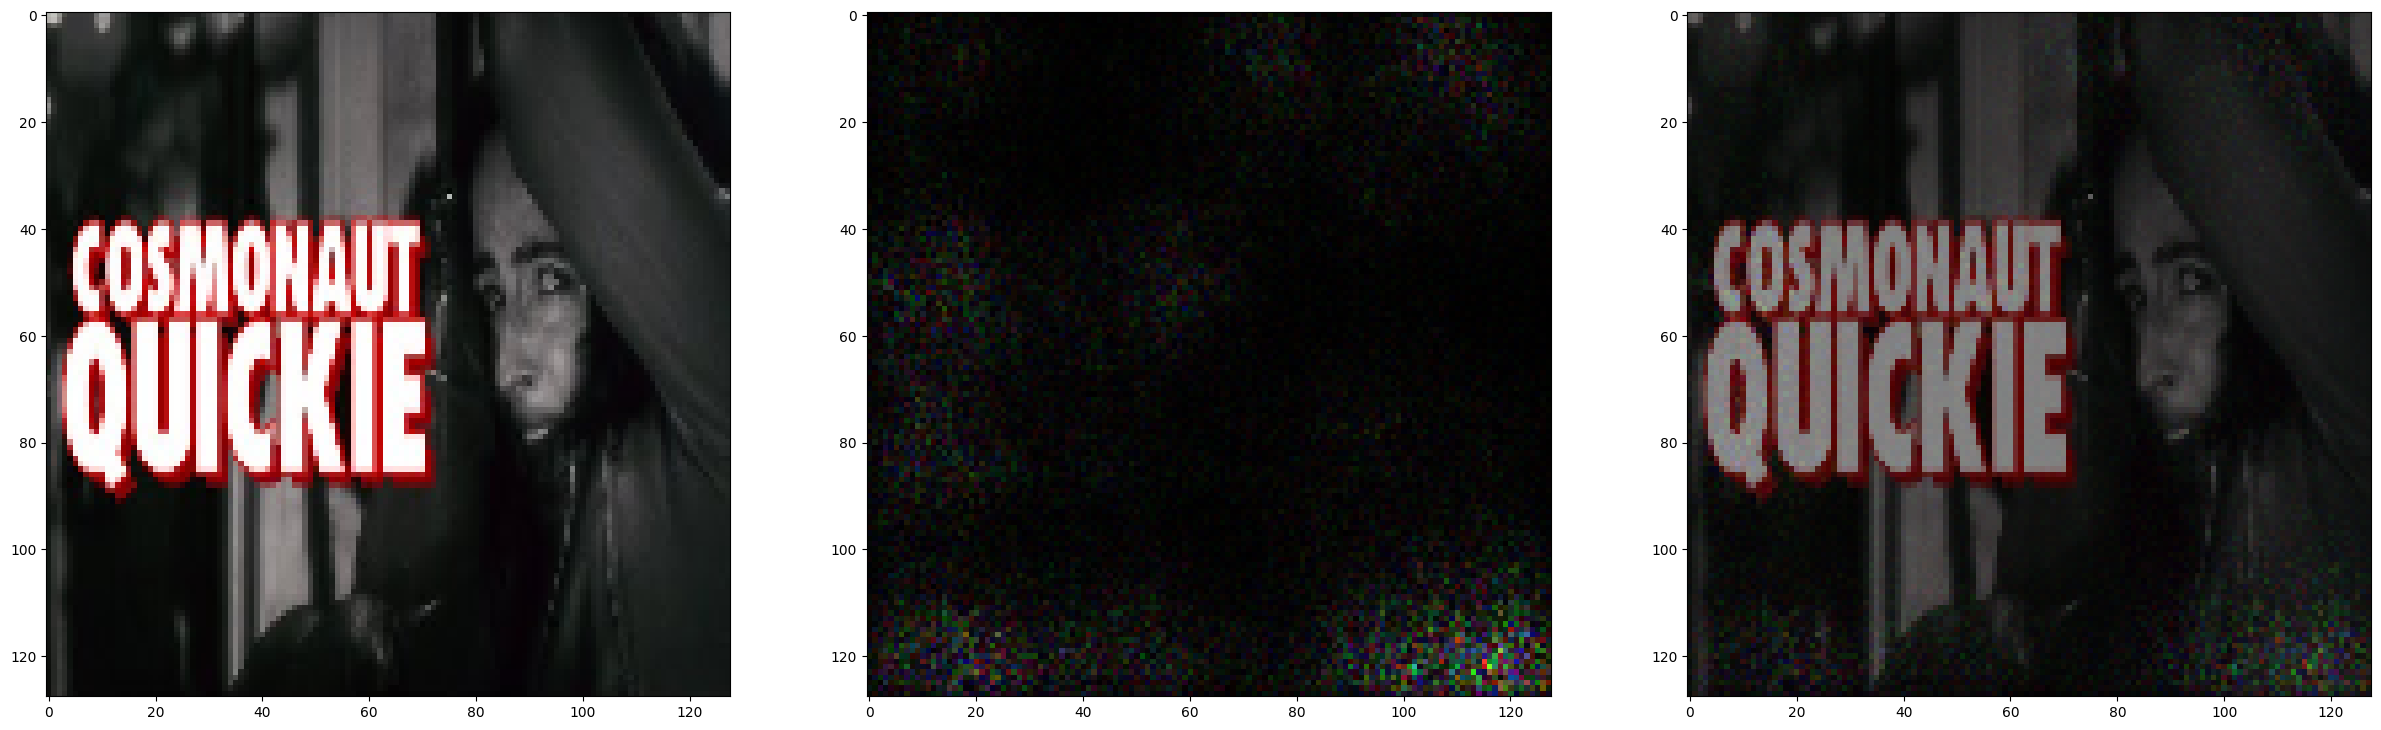

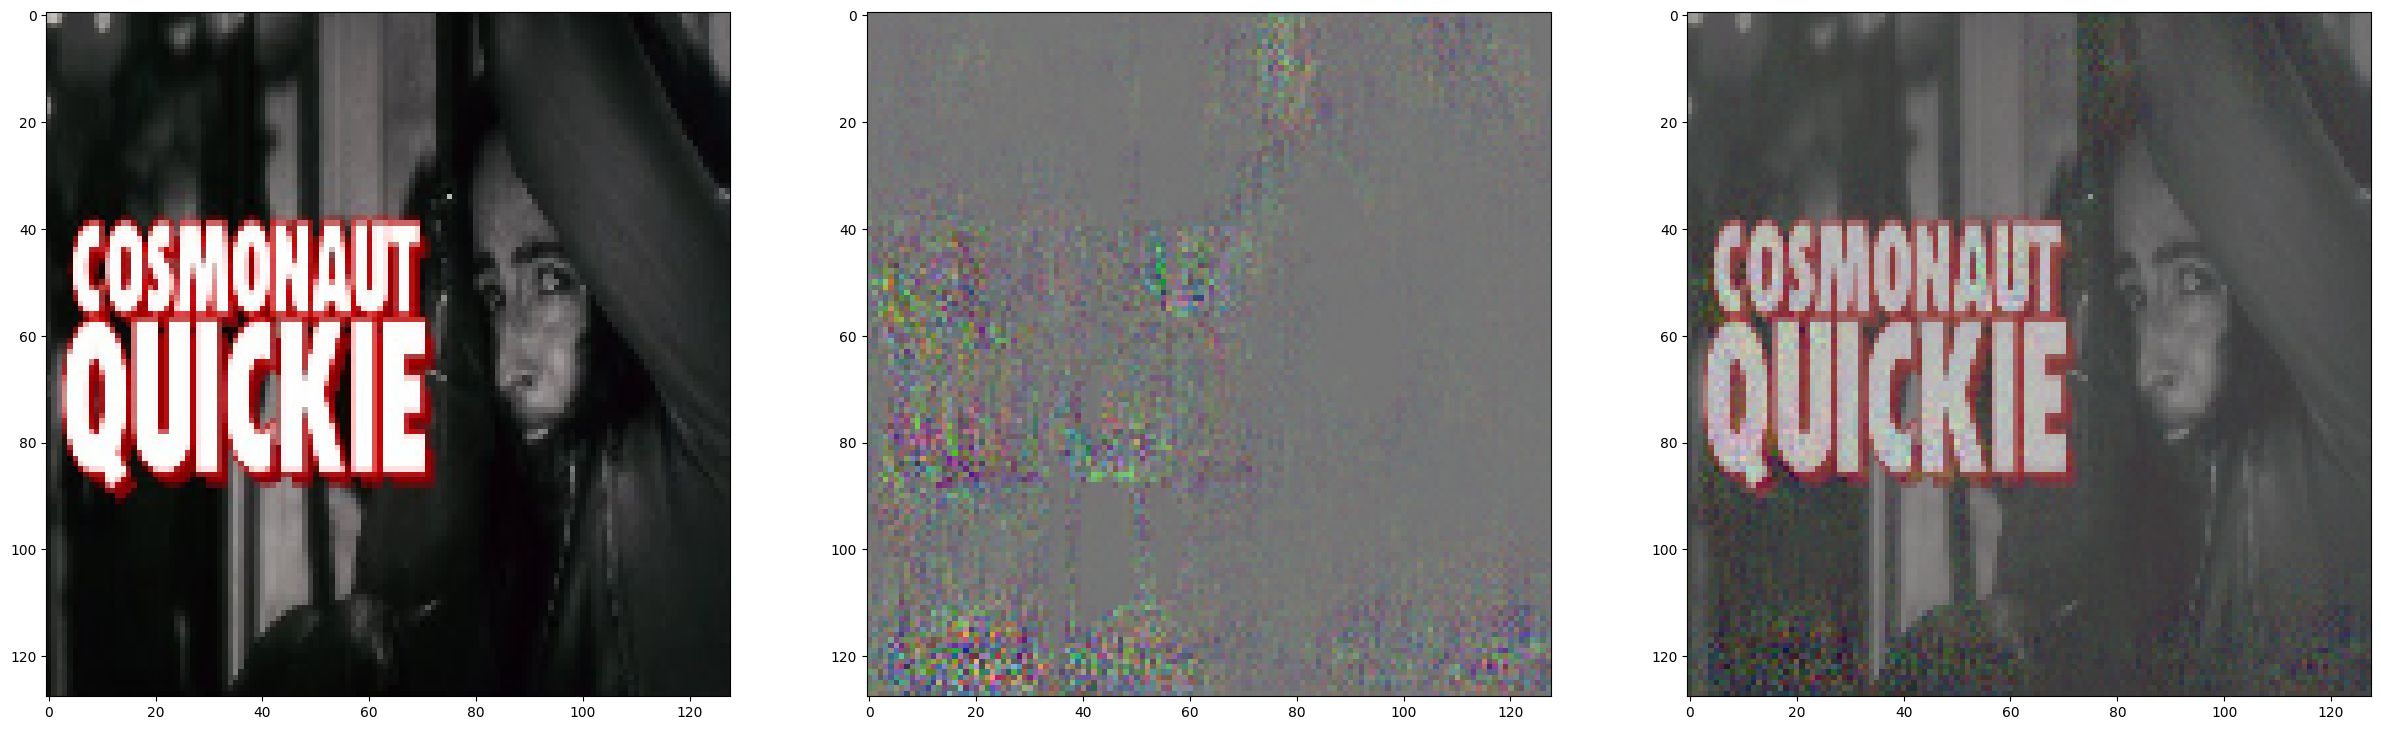

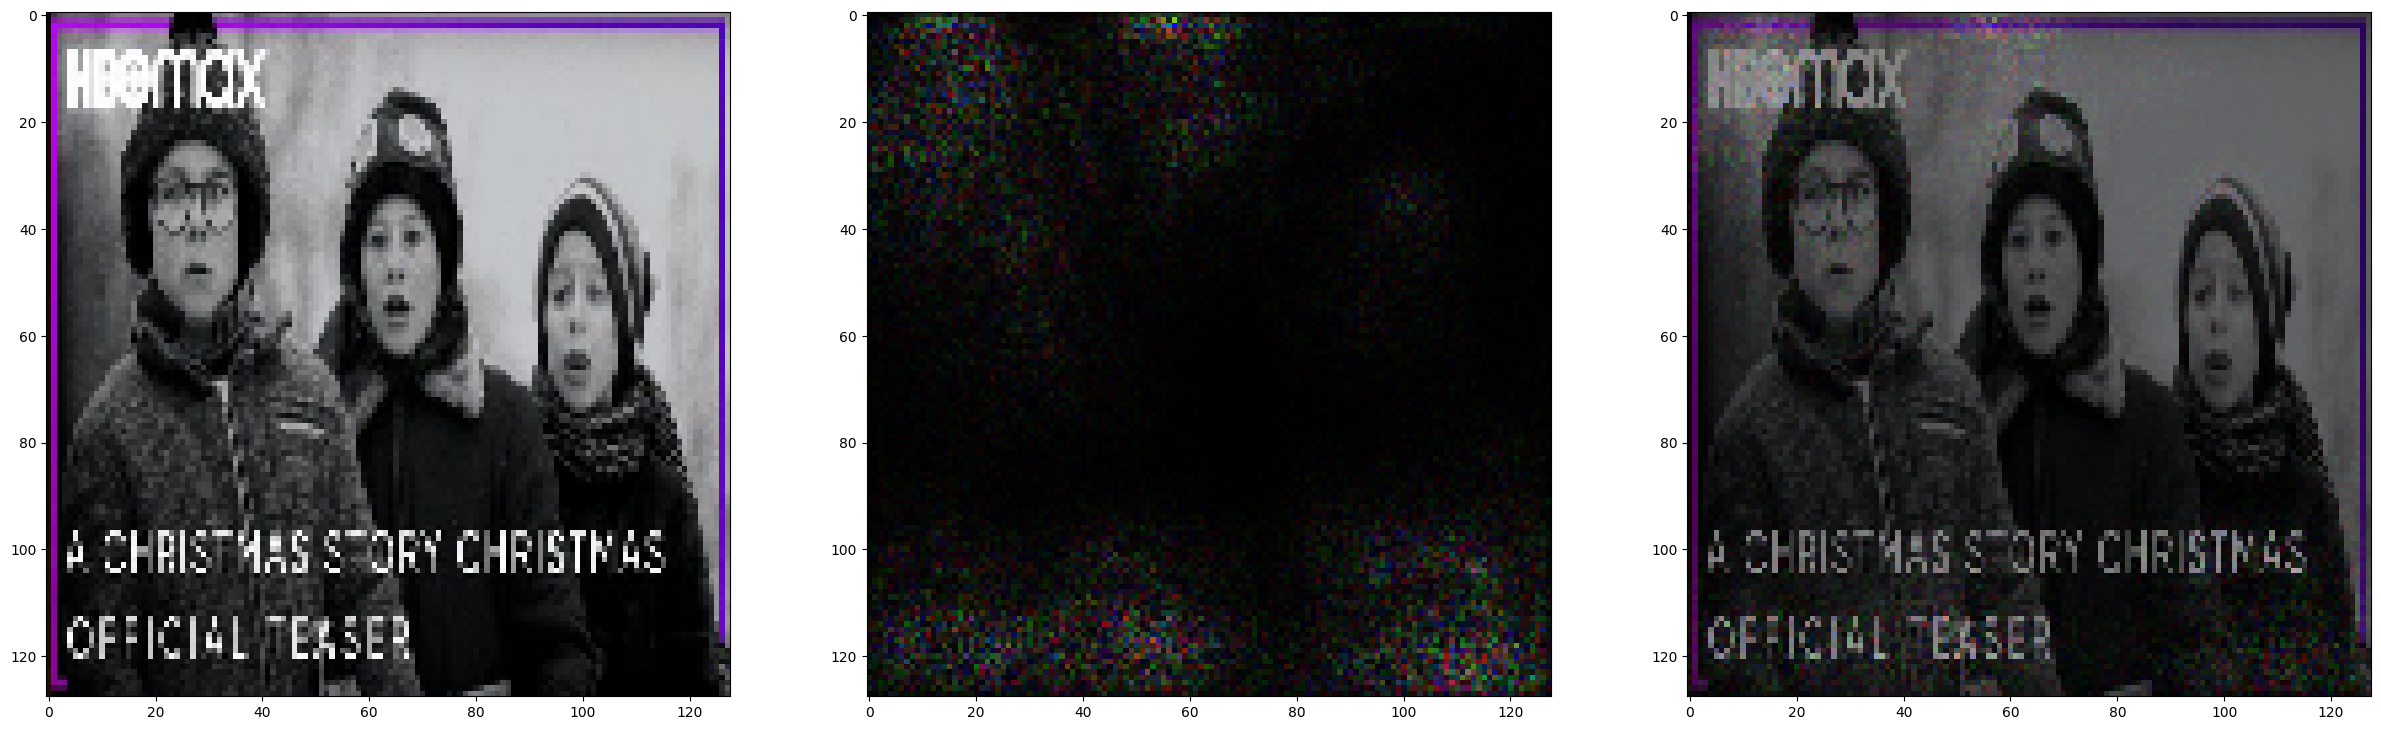

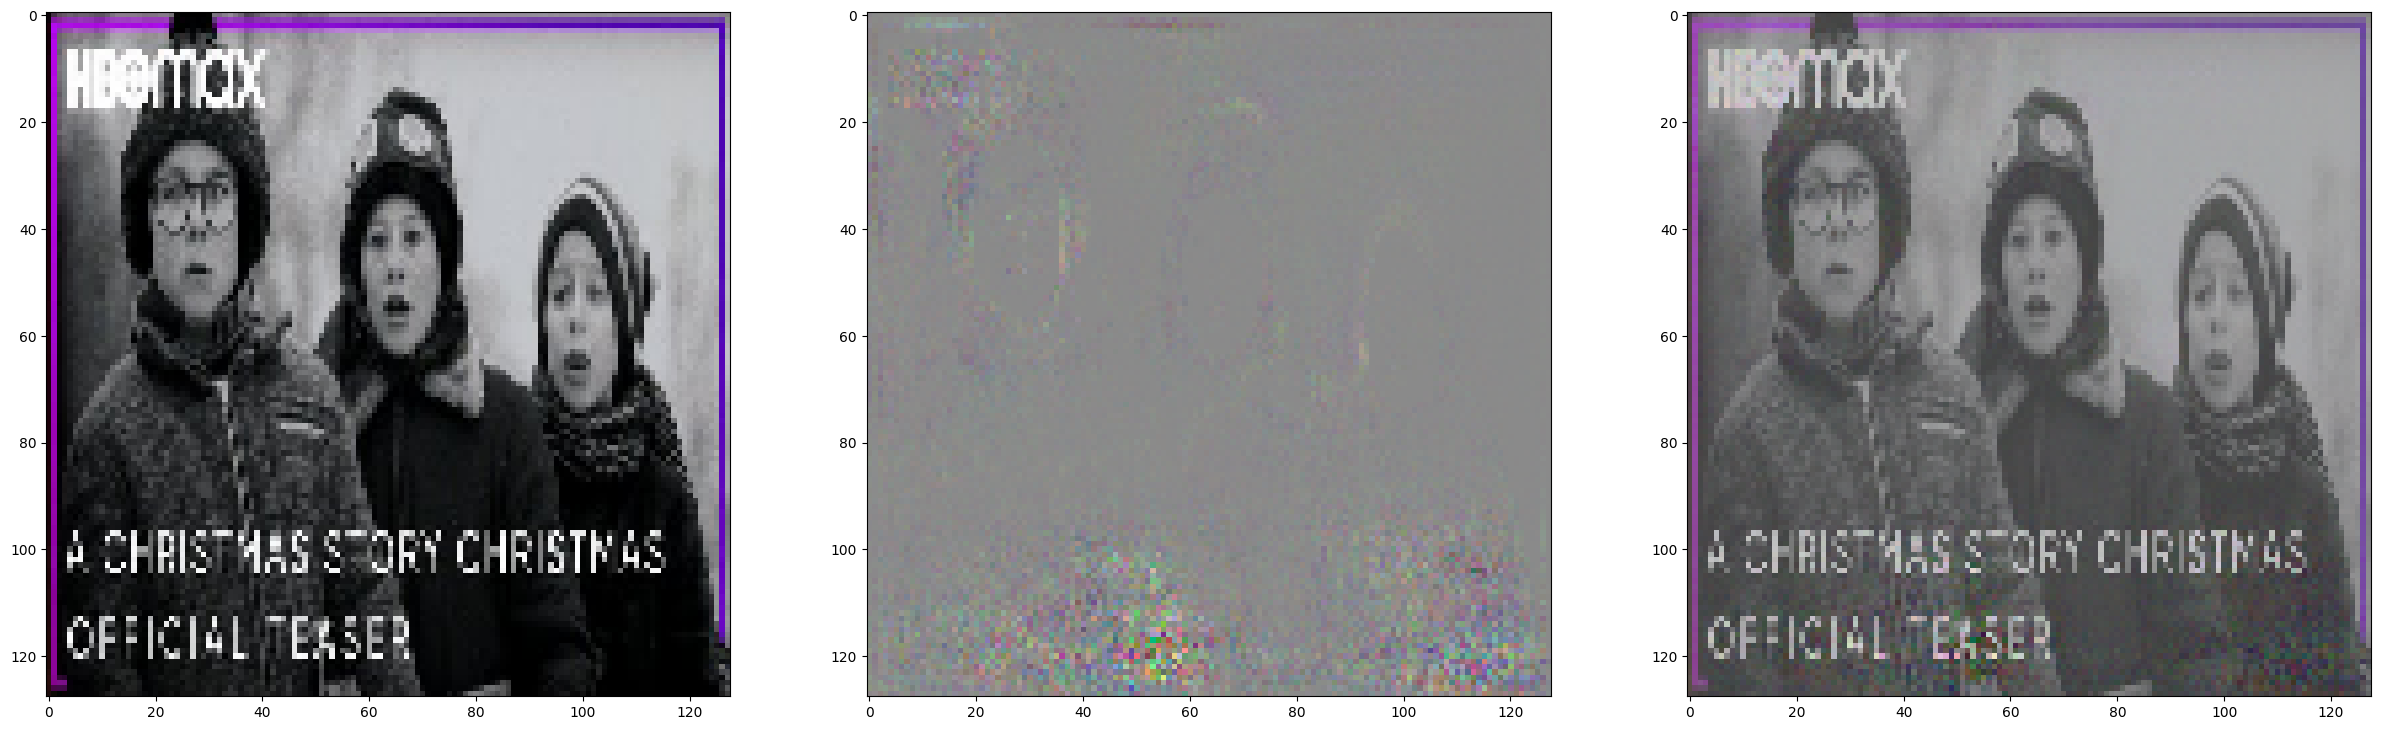

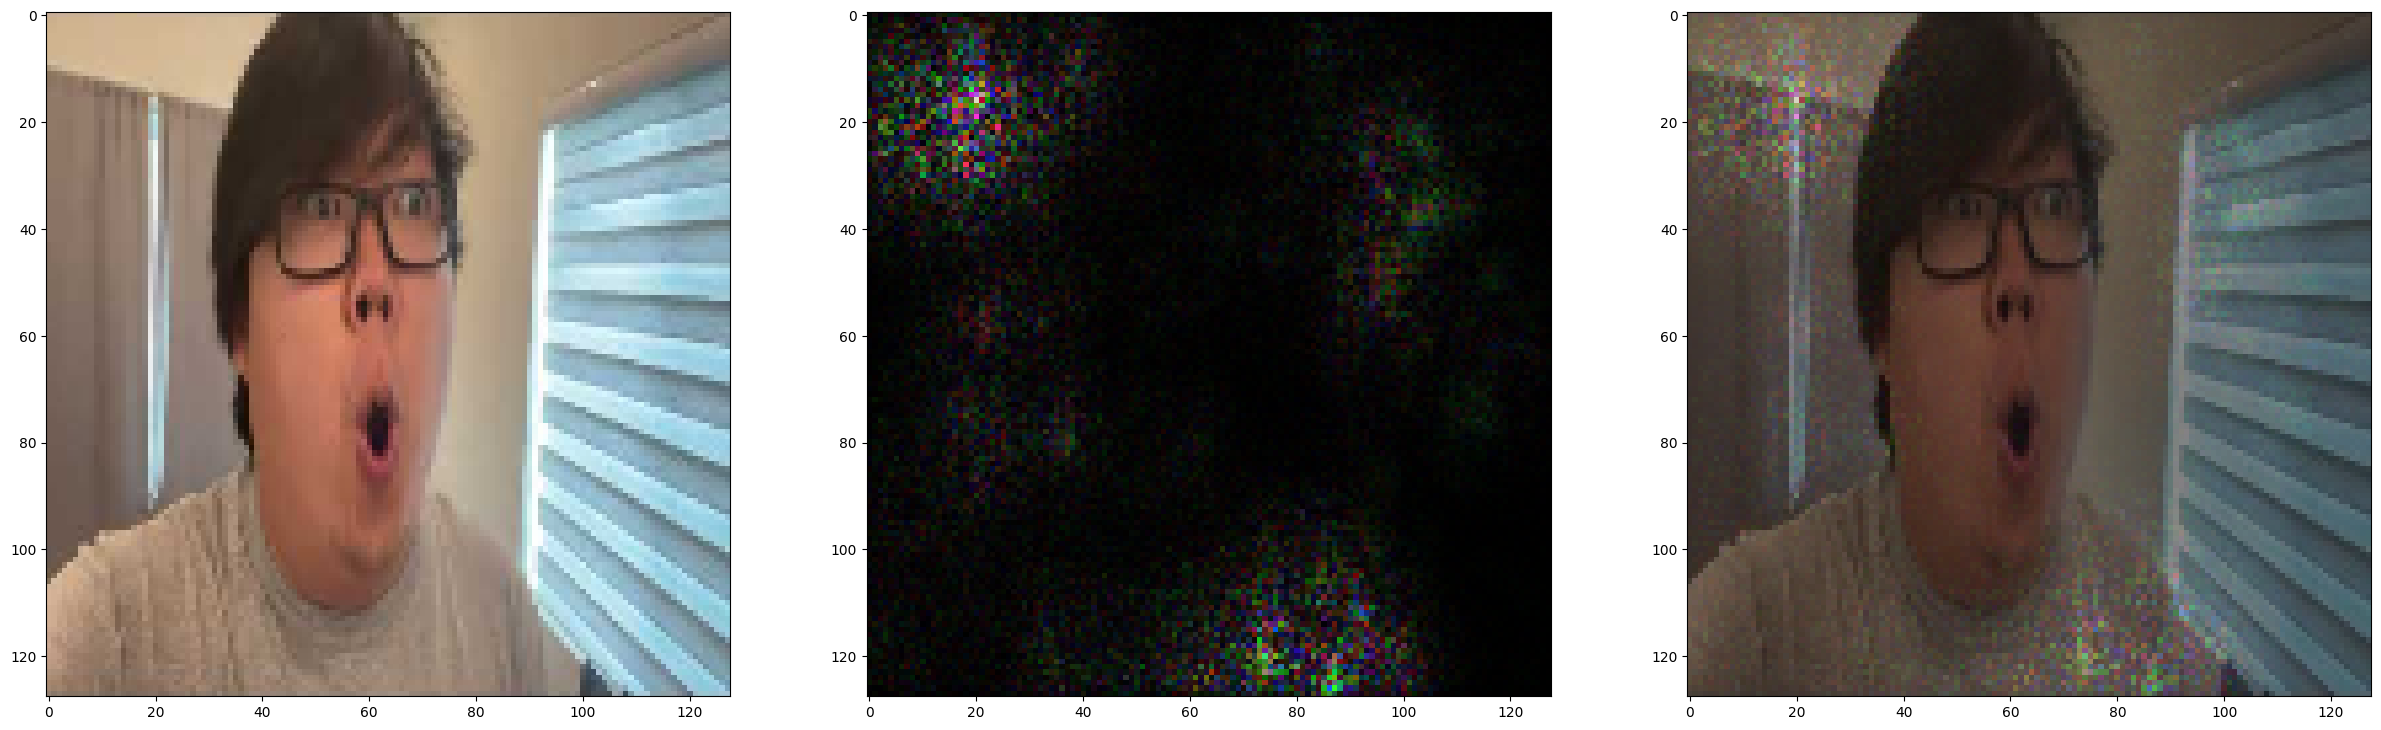

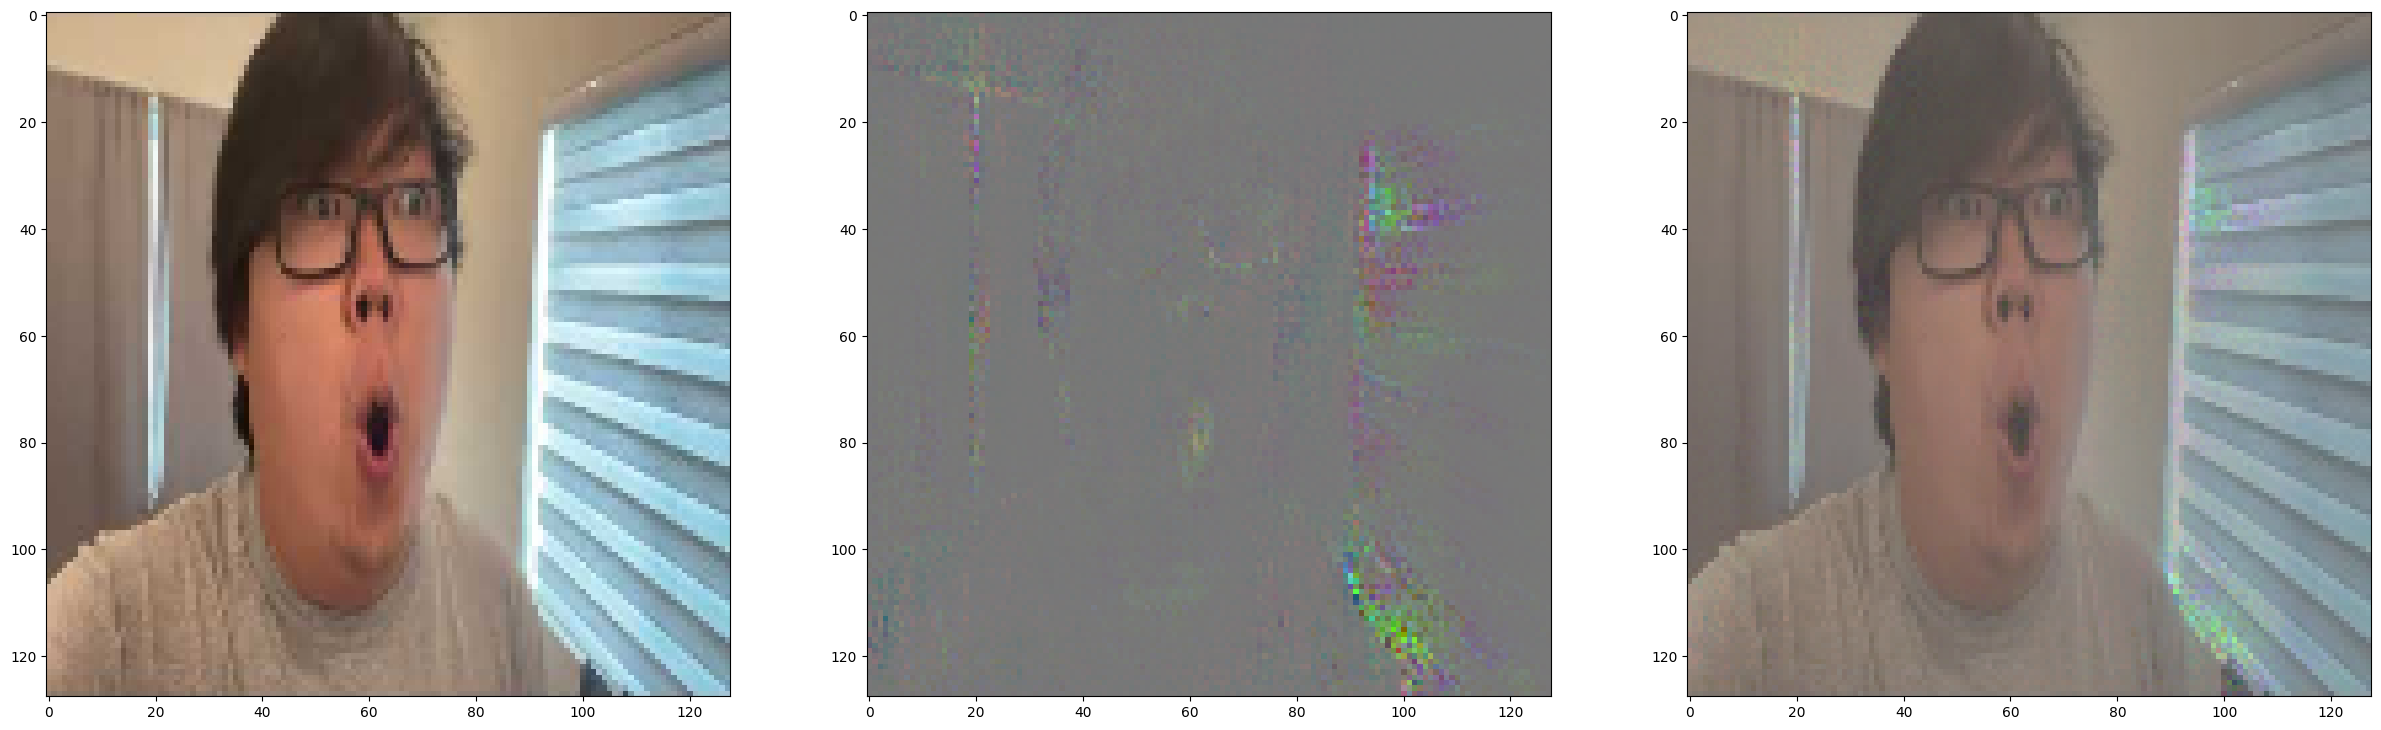

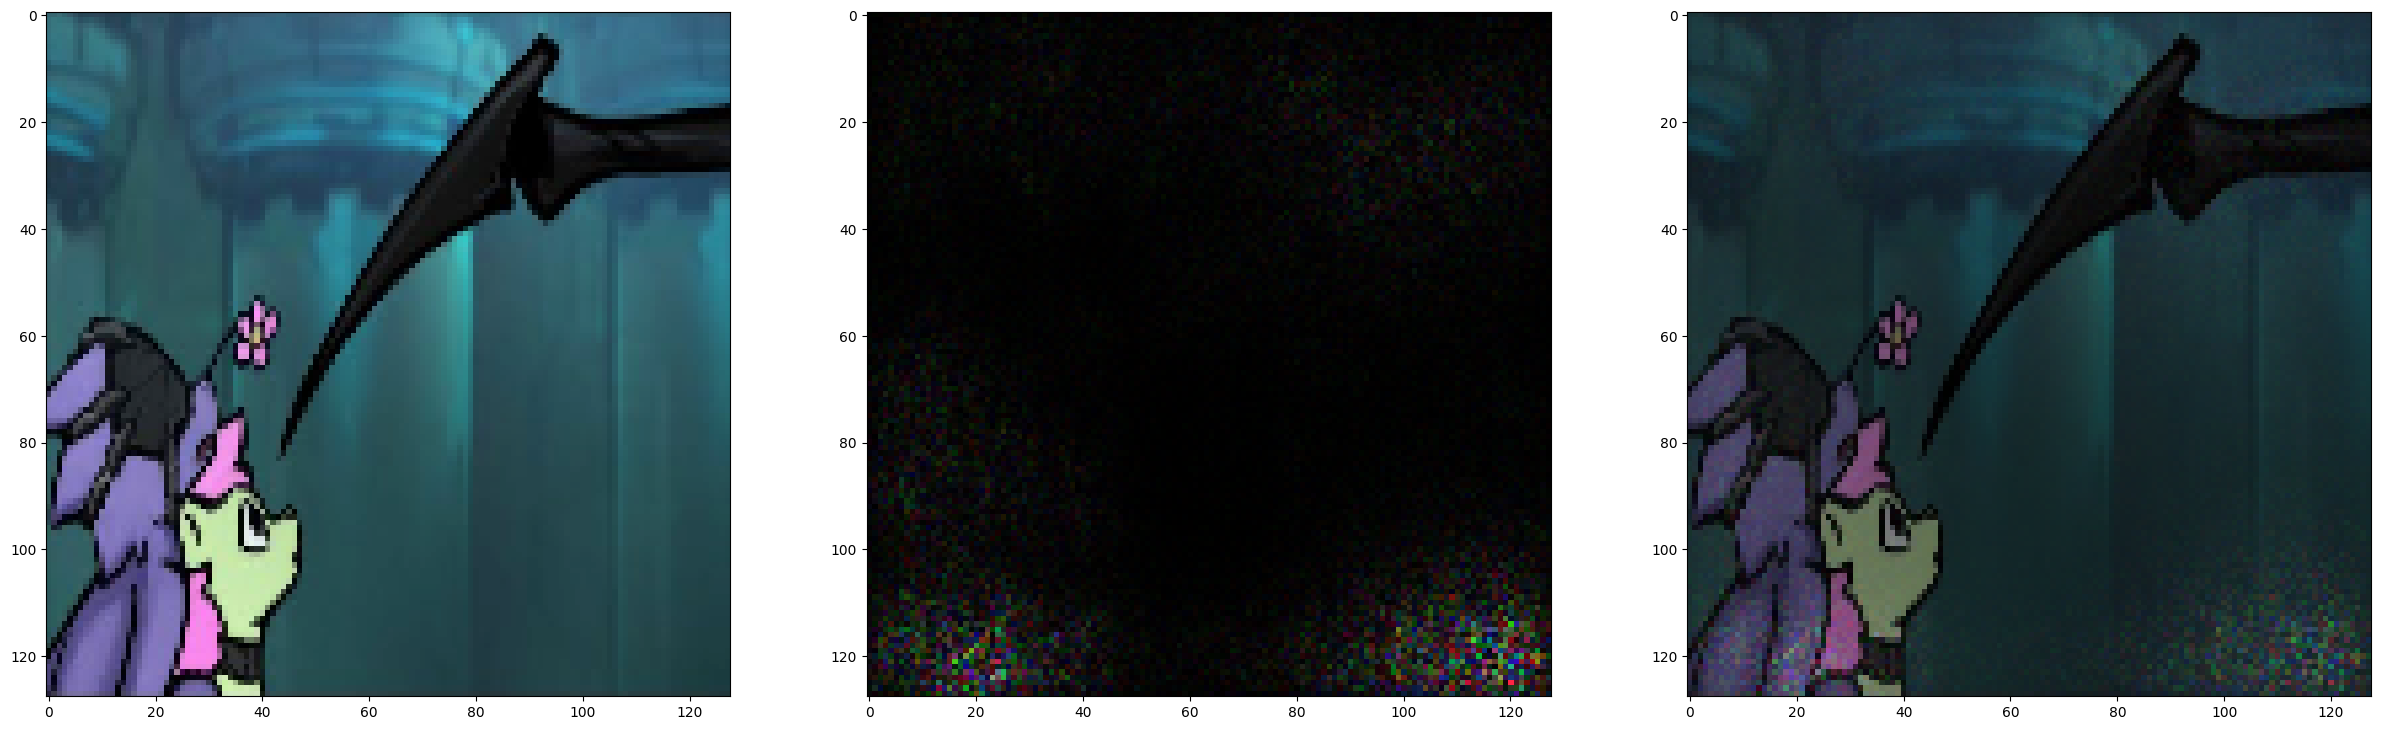

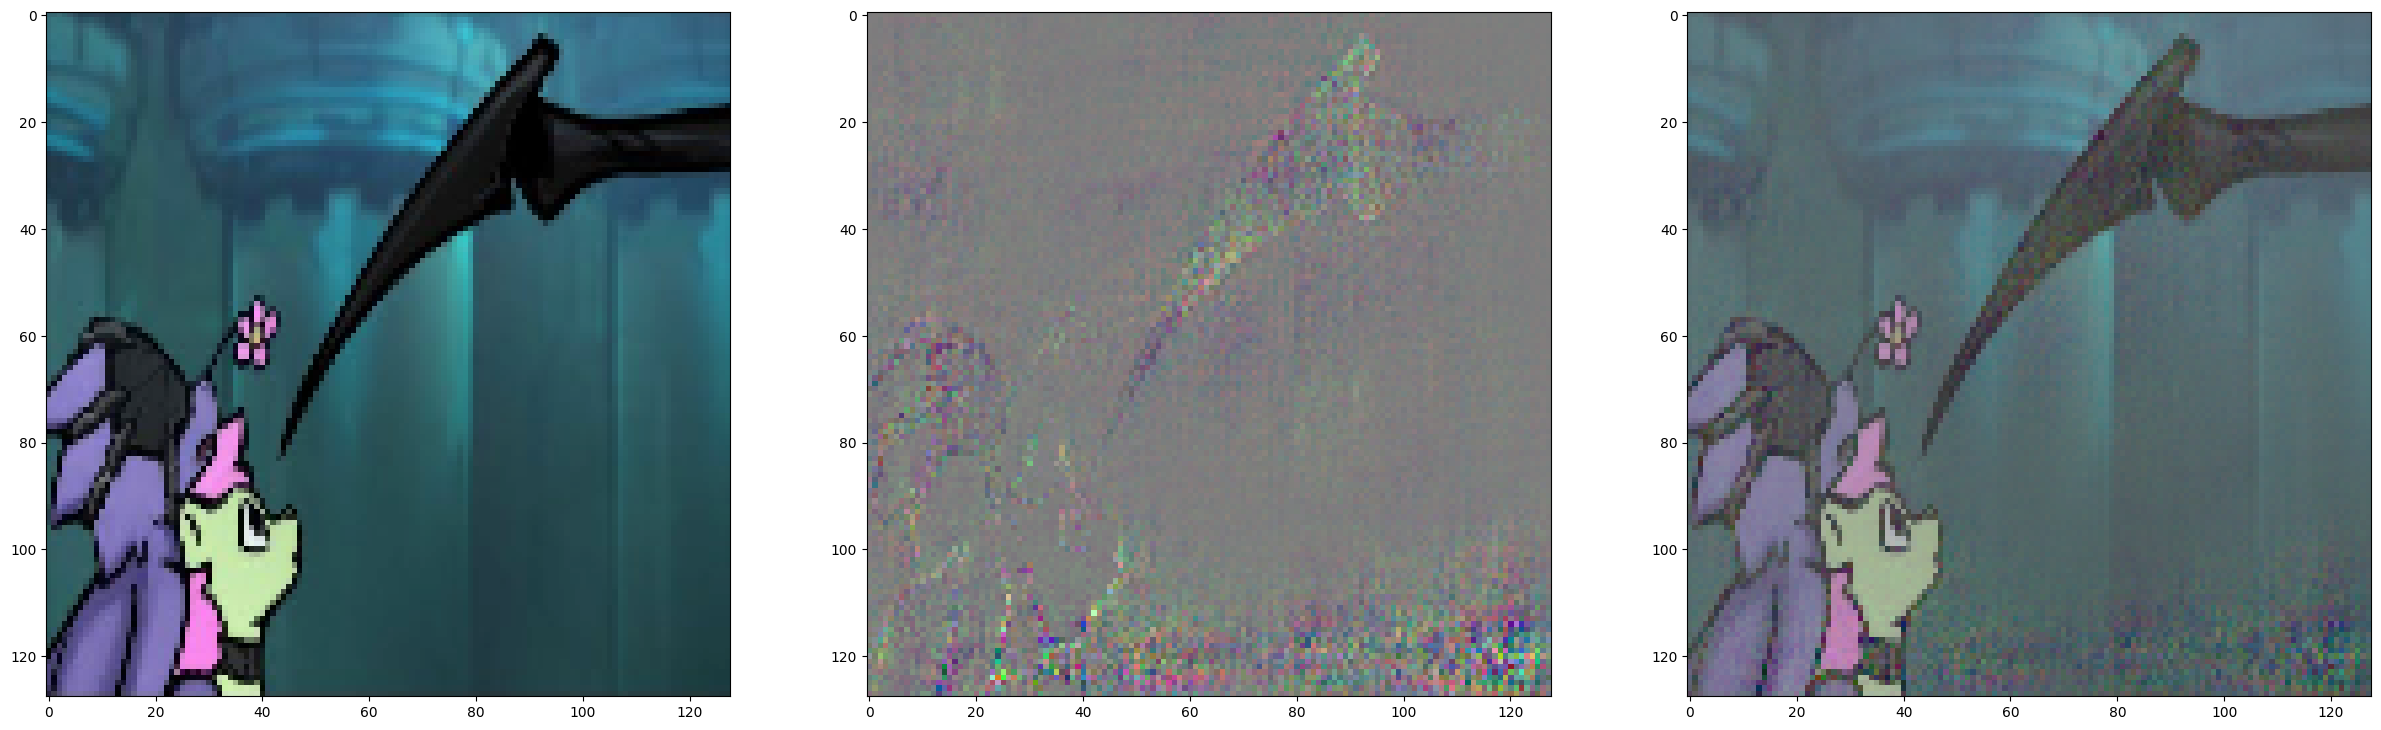

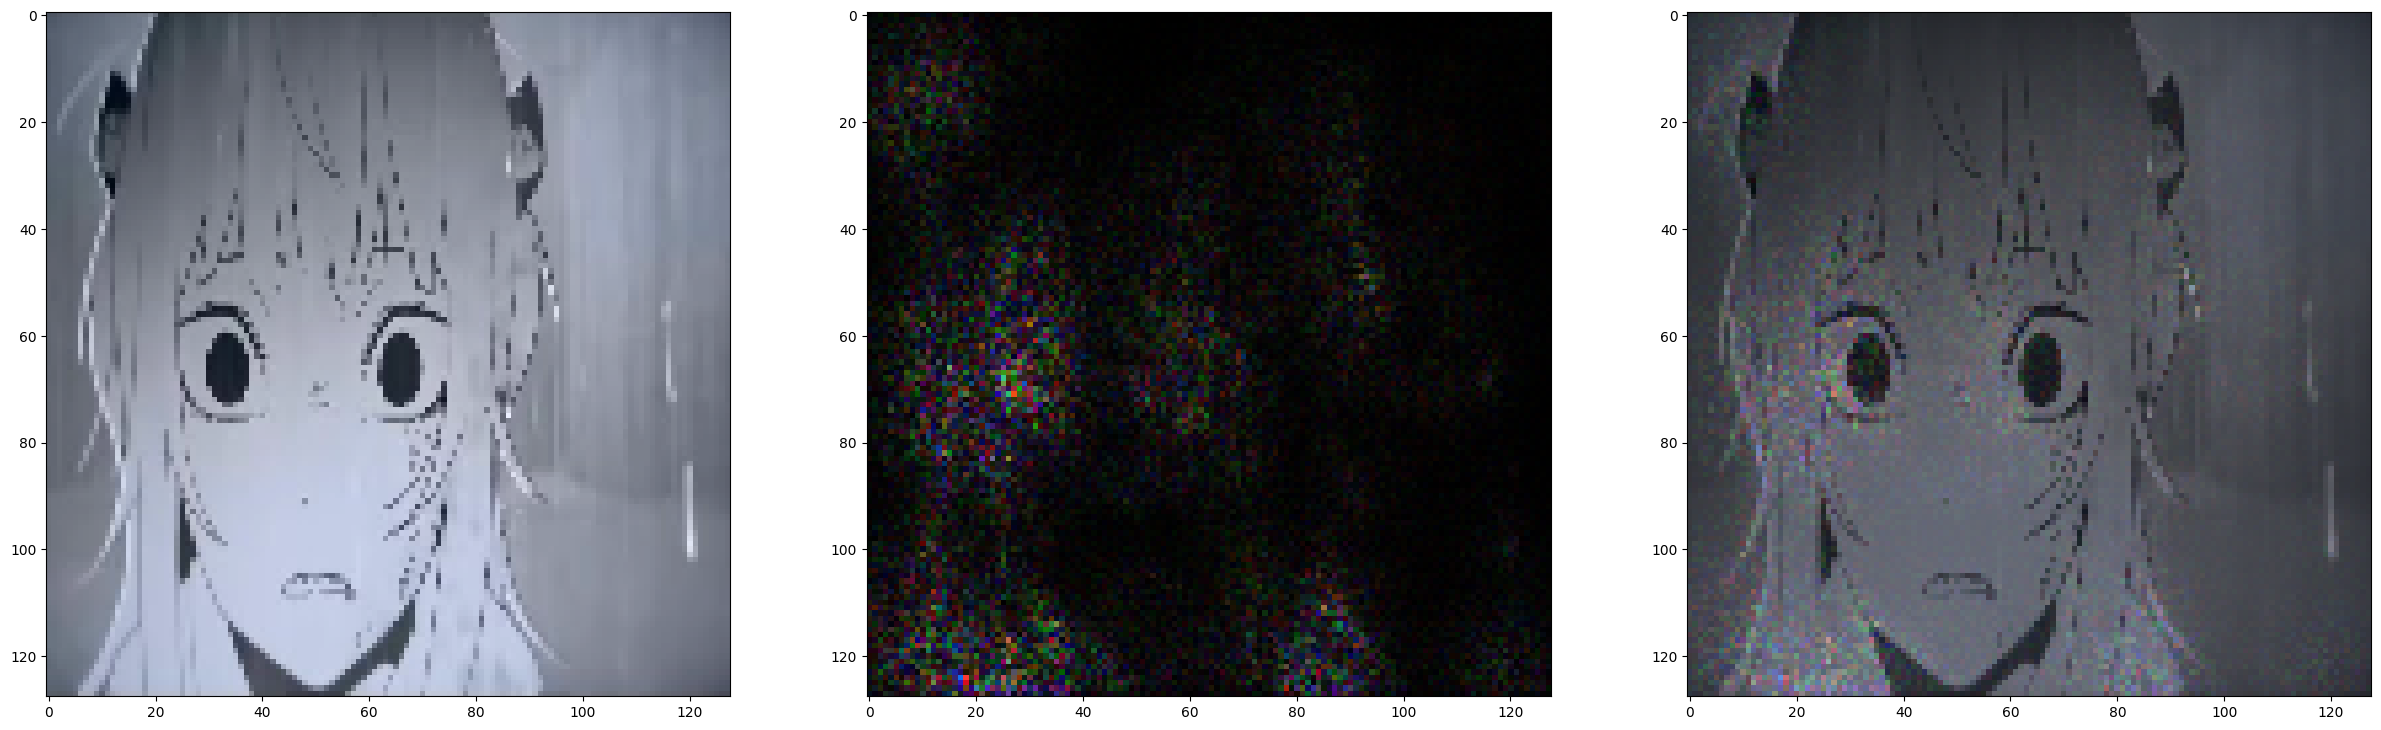

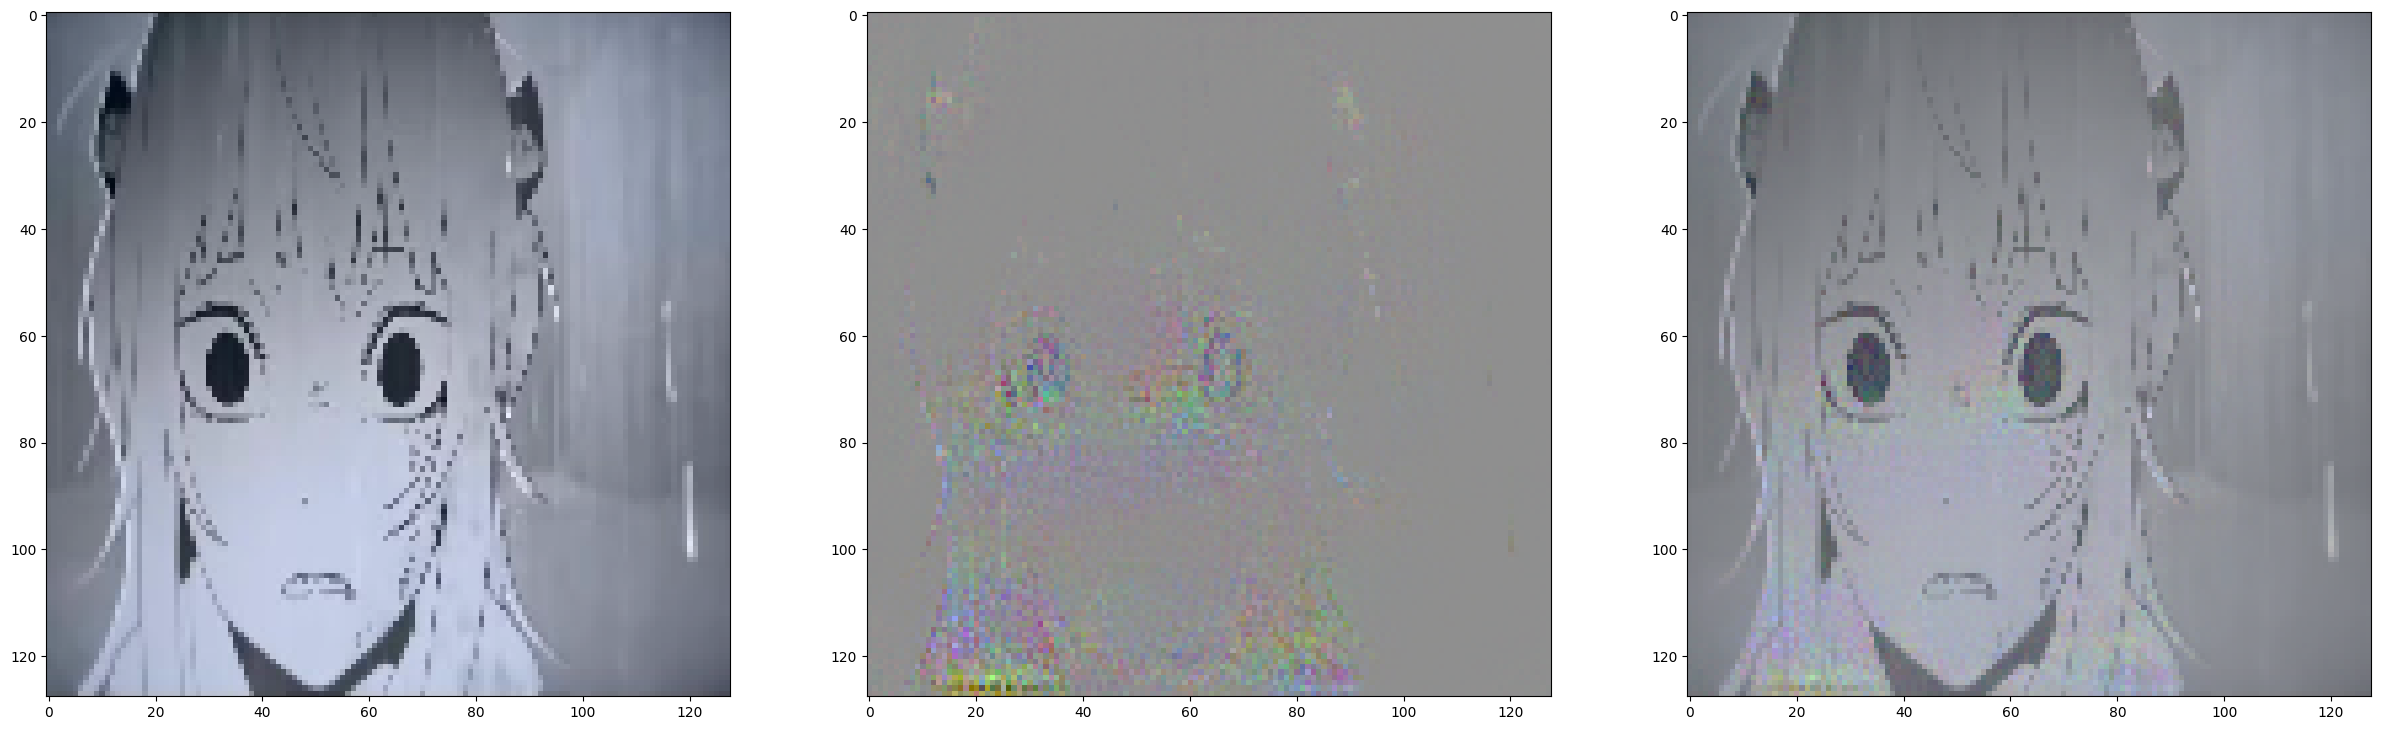

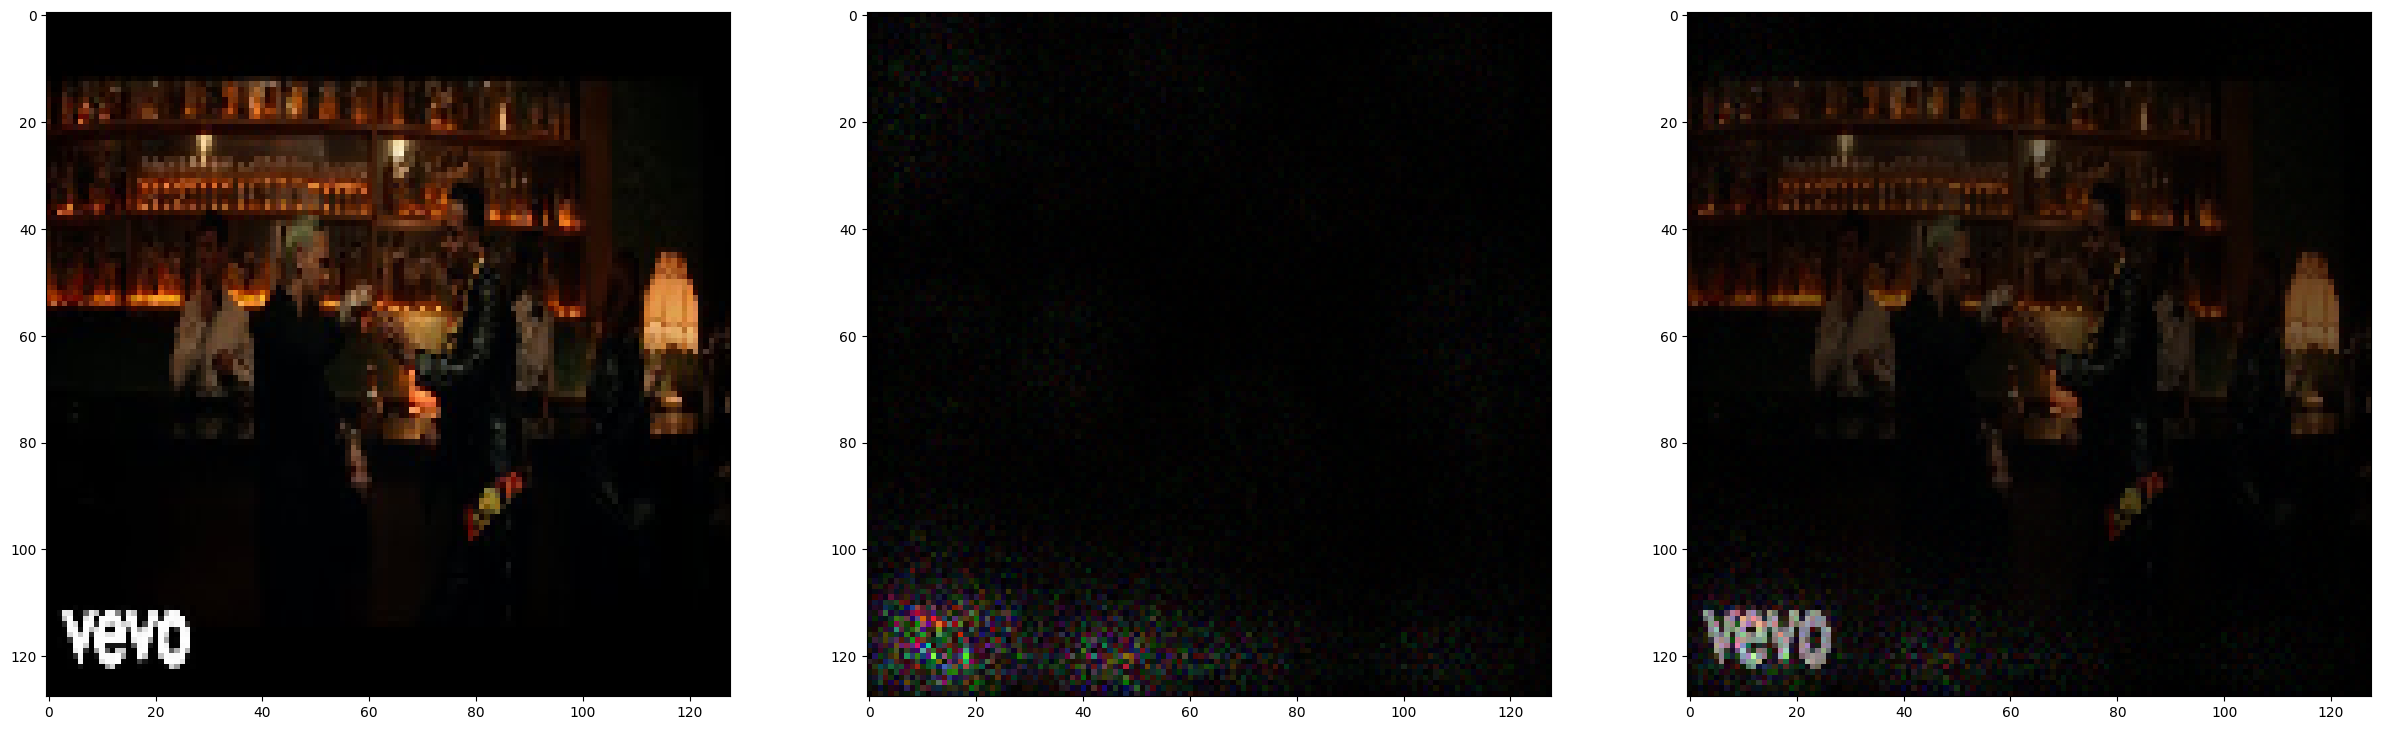

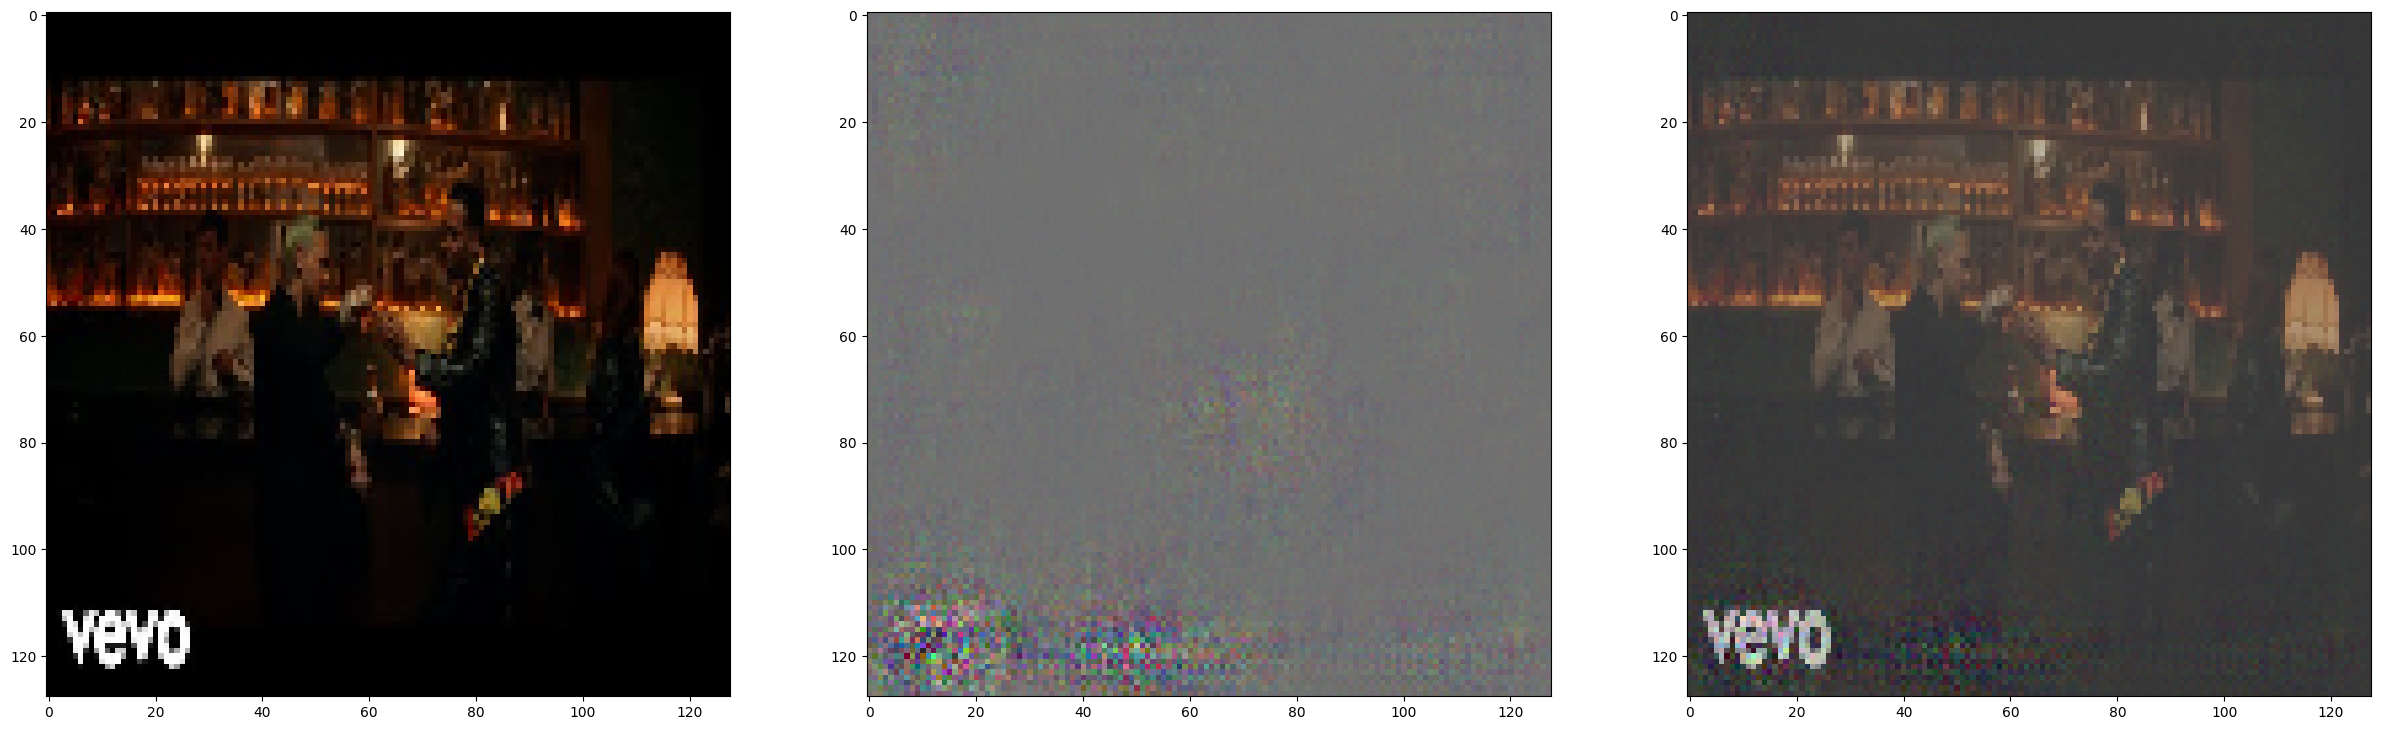

In [7]:
model.zero_grad()
model.eval()

# Saliency
saliency = Saliency(model)

# Integrated Gradients
ig = IntegratedGradients(model)

for index, value in enumerate(train_data_loader):
    sample_img, sample_label = value
    test_img = sample_img[0].unsqueeze(0).clone().requires_grad_()
    test_label = sample_label[0]

    display_img = np.transpose(test_img.squeeze().cpu().detach().numpy(), (1, 2, 0))
    
    grads = saliency.attribute(test_img, target = test_label.item())
    grads = transform_to_img(grads)

    display_attribution_and_mask(display_img, grads, 0.5)
    
    attr_ig, delta = ig.attribute(test_img, baselines = test_img * 0, return_convergence_delta = True, target = test_label)
    attr_ig = transform_to_img(attr_ig)

    display_attribution_and_mask(display_img, attr_ig, 0.5)
    
    if index == 5:
        break

In [ ]:
model.zero_grad()
model.eval()

ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = nt.attribute(test_img, baselines = test_img * 0, nt_type = "smoothgrad_sq", nt_samples = 2, stdevs = 0.2, target = test_label)
attr_ig_nt = transform_to_img(attr_ig_nt)

display_attribution_and_mask(display_img, attr_ig_nt, 0.5)